<h1>When are Traffic Accidents Likely to be Severe?</h1>

## Table of contents
* [1. Problem and Background](##1.%Problem%and%Background)
* [2. Data Gathering and Cleaning](#data)
* [3. Exploratory Analysis](#analysis)
* [4. Inferential Statistics](#logit)
* [5. Machine Learning Models and Predictions](#ml)
 * [5.1 Logistic Regression](#ml_logit)
 * [5.2 Decision Tree Model](#trees)
* [6. Discussion](#discussion)

##1. Problem and Background  
Automobile accidents kill tens of thousands of Americans every year, yet because cars are such an ingrained part of American culture, the deaths, injuries and economic loss from these accidents is rarely the target of major policy initiatives. This, combined with the ubiquity of automobiles, suggests that targeted interventions, guided by a better understanding of the data, could save lives. Local and municipal governments could use the findings of this research to establish a warning system to warn drivers when conditions are more likely to lead to more serious accidents.

<a name = data></a><h2>2. Data Gathering and Cleaning</h2>
The data is a publicly available dataset on auto accidents from the city of Seattle. The dataset consists of 37 variables documenting the different features of each recorded accident. Several, including road condition, weather, and light conditions, are plausibly important factors in accidents. Using the dataset and machine learning techniques we can analyze whether in fact these conditions are more likely to be associated with more severe accidents.

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

In [2]:
df = pd.read_csv("C:/Users/jhain/Downloads/Data-Collisions.csv",low_memory=False)

The dataset consists of 194,673 traffic accident reports, containing information on 37 variables (exclusing the key for the table - OBJECTID. These variables document the different features of each recorded accident. Several, including road condition, weather, and light conditions, are plausibly important factors in accidents.

In [3]:
df.shape

(194673, 38)

In [4]:
df.head()

,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,...,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,...,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,...,Dry,Daylight,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,...,Dry,Daylight,NaN,NaN,NaN,23,From same direction - all others,0,0,N
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,...,Wet,Daylight,NaN,4028032.0,NaN,10,Entering at angle,0,0,N


Because the data consists entirely of accident reports, we cannot use it by itself to determine under which conditions accidents are more likely to occur. Instead the target variable is the severity of the accident (where an accident cunts as "more severe" if an injury was recorded). We can see about 30% of accidents involved an injury.

In [5]:
#looking at severity, our dependent variable
#A value of 2, means there was an injury
df['SEVERITYCODE'].value_counts()

1    136485
2     58188
Name: SEVERITYCODE, dtype: int64

In [6]:
#Calculate the proportion of accidents where there as an injury
58188/(58188+136485)

0.29890123437764865

Of the 36 other variables included in the dataset, several were duplicates or re-coding of the same variable (i.e. “ADDRTYPE” and “JUNCTIONTYPE”) and many others are likely irrelevant for our analysis here. I chose to include only those which plausibly could lead to more accidents: “ADDRTYPE” (address type), “WEATHER”, “ROADCOND” (road conditions), “LIGHTCOND” (light conditions), and, because some days might then to be more likely to produce more severe accidents, “INCDATE” (incident date).

An examination of the five independent variables retained shows that they are categorical variables with multiple values.

In [7]:
df['WEATHER'].value_counts()

Clear                       111135
Raining                      33145
Overcast                     27714
Unknown                      15091
Snowing                        907
Other                          832
Fog/Smog/Smoke                 569
Sleet/Hail/Freezing Rain       113
Blowing Sand/Dirt               56
Severe Crosswind                25
Partly Cloudy                    5
Name: WEATHER, dtype: int64

In [10]:
df['ROADCOND'].value_counts()

Dry               124510
Wet                47474
Unknown            15078
Ice                 1209
Snow/Slush          1004
Other                132
Standing Water       115
Sand/Mud/Dirt         75
Oil                   64
Name: ROADCOND, dtype: int64

In [8]:
df['ADDRTYPE'].value_counts()

Block           126926
Intersection     65070
Alley              751
Name: ADDRTYPE, dtype: int64

In [12]:
df['LIGHTCOND'].value_counts()

Daylight                    116137
Dark - Street Lights On      48507
Unknown                      13473
Dusk                          5902
Dawn                          2502
Dark - No Street Lights       1537
Dark - Street Lights Off      1199
Other                          235
Dark - Unknown Lighting         11
Name: LIGHTCOND, dtype: int64

I recoded all “Unknown” or “Other” observations as NA’s. This was because these values are of little use in predicting traffic accidents and because they will interfere with the interpretation of dummy variables. Additionally, the accident severity rate for observations with "unknown" and "other" values was usually much lower than observations with other values, suggesting that in less severe accidents, information about the conditions was less likely to be collected or that responders were less likely to take detailed note of the conditions (and instead use a catchall category like “other”).

In [11]:
#Coding NAs
for j in range (df.ROADCOND.shape[0]):
    if (df['ROADCOND'][j]=='Unknown')|(df['ROADCOND'][j]=='Other'):
        df['ROADCOND'][j] <- 'NA' 

In [13]:
for j in range (df.WEATHER.shape[0]):
    if (df['WEATHER'][j]=='Unknown')|(df['WEATHER'][j]=='Other'):
        df['WEATHER'][j] <- 'NA' 

In [15]:
for j in range (df.LIGHTCOND.shape[0]):
    if (df['LIGHTCOND'][j]=='Unknown')|(df['LIGHTCOND'][j]=='Other'):
        df['LIGHTCOND'][j] <- 'NA'

I converted “INCDATE” to a date/time variable (“Dayofweek”) using Python’s dt.dayofweek method, and then calculated which day of the week the date was. This allowed me to inspect whether certain days of the week were more likely to be associated with more severe accidents. 

In [16]:
#Convert date to date-time format and save a day of the week variable
df['INCDATE'] = pd.to_datetime(df['INCDATE'])
df['Dayofweek'] = df['INCDATE'].dt.dayofweek
df.head()

,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR,Dayofweek
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,...,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N,2
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,...,Dark - Street Lights On,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N,2
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,...,Daylight,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N,3
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,...,Daylight,NaN,NaN,NaN,23,From same direction - all others,0,0,N,4
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,...,Daylight,NaN,4028032.0,NaN,10,Entering at angle,0,0,N,2


I then saved a reduced form of the dataframe that I would use for analysis.

In [17]:
#Save the variables in a dataframe to be used for analysis.
X = df[['SEVERITYCODE','ADDRTYPE','Dayofweek','WEATHER','ROADCOND','LIGHTCOND']]

In [18]:
#Check for NAs
print(X.isnull().sum())

SEVERITYCODE       0
ADDRTYPE        1926
Dayofweek          0
WEATHER         5081
ROADCOND        5012
LIGHTCOND       5170
dtype: int64


In [19]:
#Drop the NAs
X = X.dropna()

I then converted the values for the location and the weather, road, and light conditions into dummies and dropped the values that would serve as the base comparison. For “WEATHER, I dropped “Clear” so that the values on weather conditions should be understood to be in contrast to “clear” weather conditions. For the road conditions dummies, I dropped “Dry”; for the light conditions, I will drop “Daylight”; and for address type, I dropped “Block” (meaning the center of a block rather than an intersection or alley).

In [20]:
#Create dummies of the light conditions, drop the NA dummy. I will drop the 'Daylight' dummy below, once I
#have used it for a histogram.
X = pd.concat([X,pd.get_dummies(X['LIGHTCOND'])],axis=1)
X.drop(['NA'], axis = 1,inplace=True)

In [21]:
X.head()

,SEVERITYCODE,ADDRTYPE,Dayofweek,WEATHER,ROADCOND,LIGHTCOND,Dark - No Street Lights,Dark - Street Lights Off,Dark - Street Lights On,Dark - Unknown Lighting,Dawn,Daylight,Dusk
0,2,Intersection,2,Overcast,Wet,Daylight,0,0,0,0,0,1,0
1,1,Block,2,Raining,Wet,Dark - Street Lights On,0,0,1,0,0,0,0
2,1,Block,3,Overcast,Dry,Daylight,0,0,0,0,0,1,0
3,1,Block,4,Clear,Dry,Daylight,0,0,0,0,0,1,0
4,2,Intersection,2,Raining,Wet,Daylight,0,0,0,0,0,1,0


In [22]:
#Create dummies of the road conditions, drop the NA dummy and the 'dry' dummy, which will be the contrast category.
X = pd.concat([X,pd.get_dummies(X['ROADCOND'])],axis=1)
X.drop(['NA'], axis = 1,inplace=True)
X.drop(['Dry'], axis = 1,inplace=True)

In [23]:
#Create dummies of the weather conditions, drop the NA dummy and the 'dry' dummy, which will be the contrast category.
X = pd.concat([X,pd.get_dummies(X['WEATHER'])],axis=1)
X.drop(['NA'], axis = 1,inplace=True)
X.drop(['Clear'], axis = 1,inplace=True)

In [24]:
#Create dummies of the address type. Drop the 'block' dummy, which will be the contrast category.
X = pd.concat([X,pd.get_dummies(X['ADDRTYPE'])],axis=1)
X.drop(['Block'], axis = 1,inplace=True)

There were only five observations that were labeled “Partly Cloudy”. To reduce the number of dummy variables, I included the “Partly Cloudy” observations under “Overcast.” In such a large dataset this should not affect any analysis.

In [25]:
#'Partly Cloudy' only had 5 observations. I lump it with overcast
X['Overcast'] = X['WEATHER'].apply(lambda x: 1 if (x=='Overcast')|(x=='Partly Cloudy')  else 0)

In [26]:
#Drop partly cloudy
X.drop(['Partly Cloudy'], axis = 1,inplace=True)

Once the NA’s were coded and removed, the variables not of interest were dropped, and the dummies coded, I was left with a dataset with 23 predictors, one target variable, and 187,525 observations.

In [27]:
X.columns

Index(['SEVERITYCODE', 'ADDRTYPE', 'Dayofweek', 'WEATHER', 'ROADCOND',
       'LIGHTCOND', 'Dark - No Street Lights', 'Dark - Street Lights Off',
       'Dark - Street Lights On', 'Dark - Unknown Lighting', 'Dawn',
       'Daylight', 'Dusk', 'Ice', 'Oil', 'Sand/Mud/Dirt', 'Snow/Slush',
       'Standing Water', 'Wet', 'Blowing Sand/Dirt', 'Fog/Smog/Smoke',
       'Overcast', 'Raining', 'Severe Crosswind', 'Sleet/Hail/Freezing Rain',
       'Snowing', 'Alley', 'Intersection'],
      dtype='object')

In [28]:
#Separate out the DV and make it binary; takes value of 1 if there was an injury in the crash
#code severity to be 0 or 1
X['SEVERITYCODE']= X['SEVERITYCODE']-1
y = X['SEVERITYCODE']

In [29]:
X.SEVERITYCODE.value_counts()

0    130642
1     56883
Name: SEVERITYCODE, dtype: int64

In [30]:
#Finally rename the columns that include slashes
X = X.rename(columns={"Sand/Mud/Dirt": "Sand", "Snow/Slush": "Snow", "Fog/Smog/Smoke": "Visibility", "Sleet/Hail/Freezing Rain":"Hail"})
X = X.rename(columns={"Blowing Sand/Dirt": "Dusty", "Severe Crosswind": "Crosswind"})
X = X.rename(columns={"Dark - No Street Lights": "No_lights", 'Dark - Street Lights Off': 'Lights_off','Dark - Street Lights On': 'Lights_on', 'Dark - Unknown Lighting': 'Dark_unknown'})

In [31]:
X = X.rename(columns={"Standing Water": "Water"})

With the data prepared, we can now continue our inspection of it.

<a name=analysis></a> <h2>3. Exploratory Analysis</h2>

In [32]:
import seaborn as sns

As a first pass at the data, I look at how the target variable (accident severity) varies with the predictors. Below I examine the injury (severity) rate by light, road, and weather conditions. Given that the vast majority of accidents occur under daytime, dry, clear conditions, a numerical comparison rather than a visual comparison is better able to detect disparities.

In [33]:
X.groupby(['LIGHTCOND'])['SEVERITYCODE'].value_counts(normalize=True)

LIGHTCOND                 SEVERITYCODE
Dark - No Street Lights   0               0.781127
                          1               0.218873
Dark - Street Lights Off  0               0.733953
                          1               0.266047
Dark - Street Lights On   0               0.701053
                          1               0.298947
Dark - Unknown Lighting   0               0.636364
                          1               0.363636
Dawn                      0               0.669611
                          1               0.330389
Daylight                  0               0.667181
                          1               0.332819
Dusk                      0               0.668663
                          1               0.331337
NA                        0               0.950023
                          1               0.049977
Name: SEVERITYCODE, dtype: float64

In [34]:
X.groupby(['ROADCOND'])['SEVERITYCODE'].value_counts(normalize=True)

ROADCOND        SEVERITYCODE
Dry             0               0.677531
                1               0.322469
Ice             0               0.773680
                1               0.226320
NA              0               0.945376
                1               0.054624
Oil             0               0.625000
                1               0.375000
Sand/Mud/Dirt   0               0.698630
                1               0.301370
Snow/Slush      0               0.833669
                1               0.166331
Standing Water  0               0.738739
                1               0.261261
Wet             0               0.667535
                1               0.332465
Name: SEVERITYCODE, dtype: float64

Unexpectedly, dark conditions usually seem to be associated with less severe accidents. This may be because people drive slower at night or pay more attention. Another unexpected finding was that icy and snowy road conditions seem to be associated with less severe accidents. Most likely this is due to drivers driving more slowly and/or icy and snowy conditions leading to larger numbers of minor accidents (e.g., a car sliding into another). Wet and dry road conditions also appear to lead to equally severe accidents, although it remains to be seen if this similarity withstands more careful analysis.

In [35]:
X.groupby(['WEATHER'])['SEVERITYCODE'].value_counts(normalize=True)

WEATHER                   SEVERITYCODE
Blowing Sand/Dirt         0               0.734694
                          1               0.265306
Clear                     0               0.676730
                          1               0.323270
Fog/Smog/Smoke            0               0.669627
                          1               0.330373
NA                        0               0.939120
                          1               0.060880
Overcast                  0               0.683678
                          1               0.316322
Partly Cloudy             1               0.600000
                          0               0.400000
Raining                   0               0.662179
                          1               0.337821
Severe Crosswind          0               0.720000
                          1               0.280000
Sleet/Hail/Freezing Rain  0               0.758929
                          1               0.241071
Snowing                   0               0

Similar results are found for weather conditions. Snow and sleet seem to lead to less severe accidents, either by decreasing the numerator (drivers drive more slowly and carefully), increasing the denominator (a greater number of more minor accidents), or both. Clear conditions, rainy conditions, and visibility-impaired conditions (fog/smog/smoke) all seem to have about the same injury rate.

In [36]:
df.groupby(['Dayofweek'])['SEVERITYCODE'].value_counts(normalize=True)

Dayofweek  SEVERITYCODE
0          1               0.697281
           2               0.302719
1          1               0.694250
           2               0.305750
2          1               0.695705
           2               0.304295
3          1               0.692470
           2               0.307530
4          1               0.704358
           2               0.295642
5          1               0.706196
           2               0.293804
6          1               0.722022
           2               0.277978
Name: SEVERITYCODE, dtype: float64

We can see from the stacked histogram that there tend to be more accidents on Friday (for daylight conditions) and Saturday (for non-daylight conditions). 
But while accidents may be more common on those days, the accidents are not noticeably more severe (in fact the above numerical data shws that accidents on these days tended to be less severe). The histogram also shows that there tend to be more accidents, and a higher proportion of severe accidents, in the daytime

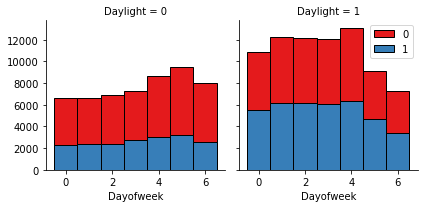

In [37]:
#In Python, day 0 is Monday, so it looks like daytime accidents peak on Friday and nighttime accidents on Saturday
g = sns.FacetGrid(X, col="Daylight", hue="SEVERITYCODE", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Dayofweek', ec="k", bins=np.arange(8)-0.5)

g.axes[-1].legend()
plt.show()


In [38]:
#Drop 'Daylight', as it will be the omitted variable for the light condition dummies.
X.drop(['Daylight'], axis = 1,inplace=True)

In [39]:
#Finally, drop ADDRTYPE, WEATHER, ROADCOND, LIGHTCOND
X.drop(['ADDRTYPE'], axis = 1,inplace=True)
X.drop(['WEATHER'], axis = 1,inplace=True)
X.drop(['ROADCOND'], axis = 1,inplace=True)
X.drop(['LIGHTCOND'], axis = 1,inplace=True)

In [40]:
#Drop the DV from the set of variables
X.drop(['SEVERITYCODE'], axis = 1,inplace=True)

In [41]:
X.columns

Index(['Dayofweek', 'No_lights', 'Lights_off', 'Lights_on', 'Dark_unknown',
       'Dawn', 'Dusk', 'Ice', 'Oil', 'Sand', 'Snow', 'Water', 'Wet', 'Dusty',
       'Visibility', 'Overcast', 'Raining', 'Crosswind', 'Hail', 'Snowing',
       'Alley', 'Intersection'],
      dtype='object')

<a name=logit></a> <h2>4. Inferential Statistics</h2>

Since the variables all range from zero to one, it is not necessary to standardize their values. Logistic regression, unlike K-Nearest Neighbors, gives coefficient estimates for each of the variables in the model. This provides some indication of what conditions are associated with more severe accidents. 

In [42]:
import statsmodels.api as sm

In [43]:
#Add a constant for the logistic regression
X = sm.add_constant(X)

In [44]:
#Fit the model and print the results
result = sm.Logit(y,X).fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.593111
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:           SEVERITYCODE   No. Observations:               187525
Model:                          Logit   Df Residuals:                   187502
Method:                           MLE   Df Model:                           22
Date:                Fri, 18 Sep 2020   Pseudo R-squ.:                 0.03349
Time:                        15:01:12   Log-Likelihood:            -1.1122e+05
converged:                       True   LL-Null:                   -1.1508e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -1.1424      0.011   -102.922      0.000      -1.164      -1.121
Dayofweek       -0.0164

From an examination of the p-values, we can see that, indeed, the later days in the week tend to be safer, and that only dusk is associated with more severe accidents than daylight. As the casual inspection in part 3 suggested, icy and snowy roads are associated with less severe accidents than dry roads. We see, however, that wet roads do in fact tend to be more dangerous. In line with this finding, rainy and overcast weather tends to be associated with more serious accidents, and snowy weather with less serious accidents. Weather that impedes visibility also was associated with more severe accidents (transforming the log-odds coefficient back to odds, we can see that impaired visibility makes a severe accident 1.22 times more likely compared to clear conditions.

The non-significance of the relatively rare conditions (not displayed), like oil on the road, dirt on the road, and severe crosswinds is likely due to the few number of observations where they occurred. Accordingly, their standard errors are much higher than for more common conditions, and it is impossible to say with great confidence whether they tend to lead to more serious accidents or not. 

Finally, intersections were significantly more dangerous, and alleys significantly less dangerous than the middle of blocks (as common sense would expect).

In [45]:
#Use the stargazer library to get output to include in the report
from stargazer.stargazer import Stargazer
from IPython.core.display import HTML

In [46]:
output = Stargazer([result])
HTML(output.render_html())

It is worth noting that the size of the coefficients are rather small. The largest positive log-odds (on the intersection variable) is 0.873. When this is exponentiated (reversing the log of the odds), we get the odds, or about 2.4 to 1. So when an accident occurs at an intersection, it is 2.4 times more likely to result in injuries than when it occurs in the middle of a block. Wet road conditions, on the other hand, while statistically significant, only result in a severe accident being 1.04 times compared to dry road conditions. 

<a name=ml></a> <h2>5. Machine Learning Models and Predictions</h2>
While the logistic model in section 4 helps to show us what conditions are likely to lead to more severe accidents, it does not show us how variables might interact (e.g., are wet roads more dangerous when visibility is low?) and there is a danger that it has been overfit to the dataset. To test how well the model does predicting accident severity, I used logistic regression with machine learning in section 5.1. In section 5.2, I developed a decision tree model that offers city officials guidance for deciding when to alert motorists to dangerous driving conditions.

Because of the need to identify specific unsafe conditions rather than simply classify accidents, kNN (which does not provide coefficient estimates) is not appropriate.

<a name=ml_logit></a> <h3>5.1 Logistic Regression</h3>

To test the predictive power of the model, I divided the dataset and target variable (accident severity) into training and testing sets (respectively consisting of 150,020 and 37,505 observations). 

In [47]:
#Train-test split the data for machine learning
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (150020, 23) (150020,)
Test set: (37505, 23) (37505,)


In [48]:
#create the model
model2 = sm.Logit(y_train,X_train)

In [49]:
#fit the model on the training data
result2 = model2.fit()

Optimization terminated successfully.
         Current function value: 0.593179
         Iterations 6


I trained a logistic model on the training data, and an inspection of the estimates (not displayed) shows them to be nearly identical to the estimates on the full data set (section 4).

In [50]:
print(result2.summary())

                           Logit Regression Results                           
Dep. Variable:           SEVERITYCODE   No. Observations:               150020
Model:                          Logit   Df Residuals:                   149997
Method:                           MLE   Df Model:                           22
Date:                Fri, 18 Sep 2020   Pseudo R-squ.:                 0.03344
Time:                        15:01:38   Log-Likelihood:                -88989.
converged:                       True   LL-Null:                       -92067.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -1.1455      0.012    -92.281      0.000      -1.170      -1.121
Dayofweek       -0.0157      0.003     -5.212      0.000      -0.022      -0.010
No_lights       -0.2693      0.069     -3.87

After the model was trained, I used it to generate predictions for the test set. Taking the mean of the predicted probabilities yields a loose measure of accuracy: the average predicted probability of an accident is .303, while the actual probability of a severe accident in the test set is also .303.

In [51]:
#use the fitted model to make predictions for the test data
yhat1 = result2.predict(X_test)

In [52]:
#compare the mean probabilities of the predictions and of the actual values
y_test.mean()

0.30315957872283694

In [53]:
yhat1.mean()

0.30336152326730353

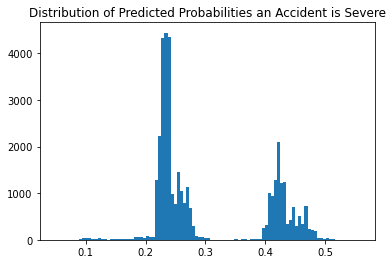

In [54]:
#Visualize the predicted probabilities
plt.hist(yhat1,100)
plt.title('Distribution of Predicted Probabilities an Accident is Severe')
plt.show()

A difficulty immediately presented itself. If the cutoff for predicting that an accident will be severe is .5, then the model will predict very few accidents (very few of the probabilities fall above .5, reflecting the fact that, even in adverse conditions, severe accidents are relatively rare). The probabilities, do, however, fall into two clear groups: those above .33 and those below .33. This, then, will be my threshold for predicting whether a severe accident will occur (1) or not (0).

In [55]:
#Set the threshold to 33%, the cut point in the histogram
yhat_prob1 = yhat1.apply(lambda x: 1 if (x>.33)  else 0)

Setting the cutoff at .33 yielded a prediction that 12,633 accidents in the test set will result in injuries. This was not far off from the actual number (11,370).

In [56]:
#Compare the total numbers of accidents predicted and those that occurred
yhat_prob1.sum()

12633

In [57]:
y_test.sum()

11370

Unfortunately, the predictive powers of the model are poor. The Jaccard score is only a very weak .296. An accuracy measure (below) shows that the model was accurate only 65.2% of the time. This is worse than simply always guessing “not severe” (which would be accurate 70% of the time). 

In [58]:
#Evaluate using Jaccard index
from sklearn.metrics import jaccard_score
jaccard_score(y_test, yhat_prob1)

0.295568629567658

The confusion matrix shows that the model had a large number of false positives and false negatives. 
The f1-score for the model was .74 for predicting accidents would not be severe and .46 for predicting that accidents would be severe, meaning that it performed much worse at the latter task.

In [59]:
#Plot confusion matrix
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
print(confusion_matrix(y_test, yhat_prob1, labels=[1,0]))

[[ 5476  5894]
 [ 7157 18978]]


Confusion matrix, without normalization
[[ 5476  5894]
 [ 7157 18978]]


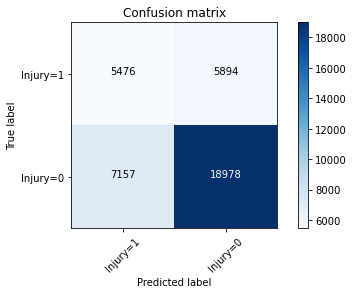

In [60]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat_prob1, labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Injury=1','Injury=0'],normalize= False,  title='Confusion matrix')

In [61]:
from sklearn.metrics import classification_report, confusion_matrix

In [62]:
import sklearn.metrics as metrics

In [63]:
#Evaluate the Accuracy
print("Model Accuracy ", metrics.accuracy_score(y_test, yhat_prob1))

Model Accuracy  0.652019730702573


In [64]:
#Evluate the f-1 score
print(confusion_matrix(y_test, yhat_prob1))
print(classification_report(y_test, yhat_prob1))

[[18978  7157]
 [ 5894  5476]]
              precision    recall  f1-score   support

           0       0.76      0.73      0.74     26135
           1       0.43      0.48      0.46     11370

    accuracy                           0.65     37505
   macro avg       0.60      0.60      0.60     37505
weighted avg       0.66      0.65      0.66     37505



<a name=trees></a> <h3>5.2 Decision Tree Model</h3>

Although the logistic model identified many statistically significant factors, it failed to predict severe accidents and failed to offer much guidance (if wet roads make the odds of a severe accident 1.04 : 1, it is not cost effective to warn drivers every time it rains (especially in Seattle!). Furthermore, issuing warnings or other interventions not only costs resources but may backfire if drivers become inured to them.

A decision tree model, then, may be more useful and provide better guidance about when drivers should be warned about dangerous driving conditions.

In [65]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [66]:
#Drop the constant used for logistic regression
X.drop(['const'], axis = 1,inplace=True)

Again, I divide the data into a training (150,020 observations) and test set (37,505 observations). I then trained a decision tree model on the training set.

In [67]:
#Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (150020, 22) (150020,)
Test set: (37505, 22) (37505,)


In [68]:
#Define the model
tree1 = DecisionTreeClassifier(criterion="entropy", max_depth = 4, random_state = 5000)

In [69]:
#Train the model
tree1.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=5000)

I used the trained model to generate predictions for the test data. The decision tree was more accurate than the logistic regression model – it predicted the correct outcome 69.7% of the time.

In [70]:
#Use the fitted model to make predictions for the test data
predtree = tree1.predict(X_test)

In [71]:
#Examine the accuracy metrics of the tree
print("Decision Trees's Accuracy: ", metrics.accuracy_score(y_test, predtree))

Decision Trees's Accuracy:  0.6968670843887481


An inspection of the confusion matrix, however, revealed that it did so by almost always guessing that an accident would not be severe! In other words, the decision tree very nearly copied simply guessing the modal outcome (it only guessed that an accident would be severe three times, and it was correct two of those three times).

In [72]:
print(confusion_matrix(y_test, predtree))
print(classification_report(y_test, predtree))

[[26134     1]
 [11368     2]]
              precision    recall  f1-score   support

           0       0.70      1.00      0.82     26135
           1       0.67      0.00      0.00     11370

    accuracy                           0.70     37505
   macro avg       0.68      0.50      0.41     37505
weighted avg       0.69      0.70      0.57     37505



Even if the predictive powers of the model were poor, it still might provide some guidance as to what conditions are more likely to lead to severe accidents. Below, I show the decision tree that was plotted on the training dataset.

In [73]:
# Load dtreeviz package
from dtreeviz.trees import dtreeviz 

In [74]:
#set PATH
import os
os.environ["PATH"] += os.pathsep + 'C:/Users/jhain/anaconda3/Library/bin/graphviz'

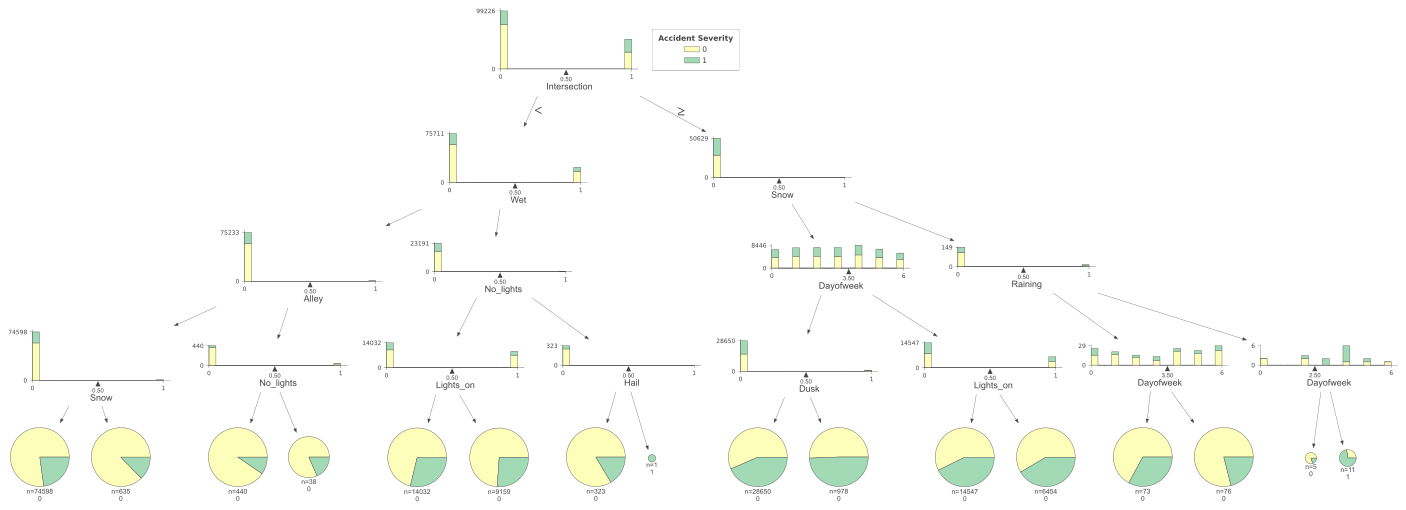

In [75]:
#Plot the tree
viz = dtreeviz(tree1, X_train, y_train,
                target_name="Accident Severity",
                feature_names=X_train.columns,
                class_names=list(-y+1))

viz

<a name=discussion></a> <h3>6. Discussion</h3>
The decision tree depicted in Figure 4 is easily interpretable. The larger the green region of the pie chart, the more likely it is that accidents under those conditions will be severe. 

As expected from the results of the logistic model, we can see that intersections are the most important factor. Examining the pie charts on the leaf nodes of the tree, we can see what conditions tend to have higher rates of severe accidents. Reading from right to left we can see that intersections where there is snow on the ground and it is raining tend to be especially dangerous, particularly from Thursdays on. When there is not snow on the ground or it is not raining, the earlier days of the week tend to see more severe accidents at intersections. For days that are earlier in the week, dusk is also associated with more severe accidents. 

For locations other than intersections, whether the road was wet tended to be the second most important factor. If the road is wet, accidents tended to be more severe. Areas where there were no street lights tended to have less serious accidents, likely because these areas might have lower driving speeds and see less traffic. The exception to this is alleys. Although the overall rate of serious accidents in alleys is low (as the regression in Table 6 showed), we can see (fourth pie chart from the left), that alleys without street lights have a much higher rate of serious accidents than alleys in other conditions.

Finally, for blocks (which are neither intersections nor alleys), snow was the most important predictor. When there was snow on the road the rate of serious accidents was much lower.

The table below shws possible recommendations based on the results of the decision tree model.

In [76]:
recommendations = {'Days':['Thursday-Sunday','Monday-Thursday','Monday-Thursday','All','All','All'],
                   'Conditions':['Snow on road, rainy','Snow on road, not rainy','All times, but especially dusk','Wet road','Blocks, no snow','Alleys with no lights'],
                   'Locations':['Intersections','Intersections','Intersections','Blocks','Blocks','Alleys'],
                   'Possible Interventions':['Warning signs, police at intersections','Warning signs, police at intersections','Warning signs, police at intersections, roundabouts','Lower speed limits','Lower speed limits','Improved Lighting']
                  }

rec = pd.DataFrame(recommendations, columns = ['Days','Conditions','Locations','Possible Interventions'])

rec

,Days,Conditions,Locations,Possible Interventions
0,Thursday-Sunday,"Snow on road, rainy",Intersections,"Warning signs, police at intersections"
1,Monday-Thursday,"Snow on road, not rainy",Intersections,"Warning signs, police at intersections"
2,Monday-Thursday,"All times, but especially dusk",Intersections,"Warning signs, police at intersections, rounda..."
3,All,Wet road,Blocks,Lower speed limits
4,All,"Blocks, no snow",Blocks,Lower speed limits
5,All,Alleys with no lights,Alleys,Improved Lighting


The decision tree model provides the most specific guidance for decision-makers even if its power to predict that an accident will be severe is weak. This guidance, however, is still useful and enables for interventions to be focused in precise ways. We can see, for example, that Monday-Thursday are more dangerous times at intersections when there is now on the road – unless it is raining, in which case Wednesday-Sunday are more dangerous.

Intersections in general proved to be rather dangerous, especially at dusk during the week, probably a result of people rushing home from work. Simply having warning signs at intersections at all times is not likely to be effective, as drivers will probably simply become used to them and ignore them. At specific times and for specific conditions, however, warning signs and a police presence might reduce accidents. When feasible, efforts to replace intersections with safer alternatives like roundabouts could be considered.  

Blocks were dangerous when it was wet and when there was no snow. These conditions, however, are too general for warning signs or targeted interventions to be effective. A more general approach, like reducing speed limits, might be better for reducing accidents on blocks. 

Finally, the results suggest that improving lighting in alleys could also reduce serious injury.

Judgments about the feasibility or desirability of these recommendations ultimately rest with decision-makers who have knowledge of the local circumstances. These findings, however, can hopefully help to guide such decision-makers and reduce the death and injury toll from traffic accidents. 